# Modeling and Simulation in Python

Chapter 15

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### The coffee cooling problem

I'll use a `State` object to store the initial temperature.


In [2]:
init = State(T=90)

,values
T,90


And a `System` object to contain the system parameters.

In [3]:
coffee = System(init=init,
                volume=300,
                r=0.01,
                T_env=22,
                t_0=0,
                t_end=30,
                dt=1)

,values
init,T 90 dtype: int64
volume,300
r,0.01
T_env,22
t_0,0
t_end,30
dt,1


The update function implements Newton's law of cooling.

In [5]:
def update_func(state, t, system):
    """Update the thermal transfer model.
    
    state: State (temp)
    t: time
    system: System object
    
    returns: State (temp)
    """
    r, T_env, dt = system.r, system.T_env, system.dt
    
    T = state.T
    T += -r * (T - T_env) * dt
    
    return State(T=T)

Here's how it works.

In [6]:
update_func(init, 0, coffee)

,values
T,89.32


Here's a version of `run_simulation` that uses `linrange` to make an array of time steps.

In [7]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    init = system.init
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

And here's how it works.

In [8]:
results = run_simulation(coffee, update_func)

,T
0,90
1,89.32
2,88.6468
3,87.9803
4,87.3205
5,86.6673
6,86.0207
7,85.3804
8,84.7466
9,84.1192


Here's what the results look like.

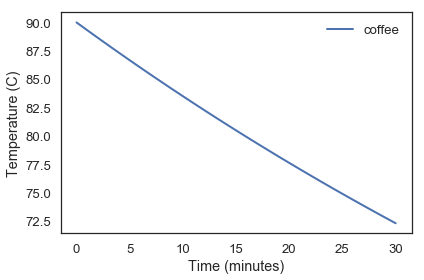

In [9]:
plot(results.T, label='coffee')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)')

And here's the final temperature:

In [10]:
coffee.T_final = get_last_value(results.T)
T_final = get_last_value(results.T)

72.2996253904031

## Encapsulation

Before we go on, let's define a function to initialize `System` objects with relevant parameters:

In [11]:
def make_system(T_init, r, volume, t_end):
    """Makes a System object with the given parameters.

    T_init: initial temperature in degC
    r: heat transfer rate, in 1/min
    volume: volume of liquid in mL
    t_end: end time of simulation
    
    returns: System object
    """
    init = State(T=T_init)
                   
    return System(init=init,
                  r=r, 
                  volume=volume,
                  temp=T_init,
                  t_0=0, 
                  t_end=t_end, 
                  dt=1,
                  T_env=22)

Here's how we use it:

In [12]:
coffee = make_system(T_init=90, r=0.01, volume=300, t_end=30)
results = run_simulation(coffee, update_func)
T_final = get_last_value(results.T)

72.2996253904031

## Exercises

**Exercise:**  Simulate the temperature of 50 mL of milk with a starting temperature of 5 degC, in a vessel with the same insulation, for 15 minutes, and plot the results.

By trial and error, find a value for `r` that makes the final temperature close to 20 C.

In [14]:
milk = make_system(T_init=5, r=0.01, volume=50, t_end=15)
results = run_simulation(milk, update_func)
T_final = get_last_value(results.T)

7.379007971098095

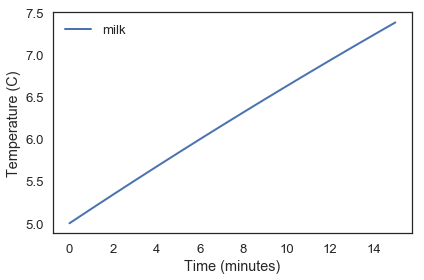

In [15]:
plot(results.T, label='milk')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)')

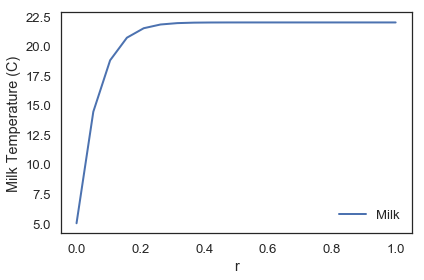

In [32]:
def findoptimumr():
    r = linspace(0,1,20)
    s = SweepSeries()
    for i in r:
        milk = make_system(T_init=5, r=i, volume=50, t_end=15)
        results = run_simulation(milk, update_func)
        T_final = get_last_value(results.T)
        s[i] = T_final
    return(s)

results = findoptimumr()
#label = 'gamma = ' + str(gamma)
plot(results, label = 'Milk')
decorate(xlabel='r',
             ylabel='Milk Temperature (C)')

### From the above plot we can see that temperature reaches to ~20 degree celcius when r = 0.15